In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ShuffleSplit
from sklearn.metrics import r2_score, f1_score, mean_squared_error as mse
from scipy.stats import uniform

In [2]:
# Data

cars_df = pd.read_csv('datasets/cars_moldova_cleaned.csv', sep=',')
cars_df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,13636.363636


In [3]:
# Helpers

RANDOM_STATE = 42

num_cols = cars_df.select_dtypes(include=np.number).columns
cat_cols = cars_df.select_dtypes(exclude=np.number).columns

def rmse(y_true, y_hat):
    return np.sqrt(mse(y_true, y_hat))

def display_metrics(*, y_hat, y_true, metrics=[mse, rmse, r2_score]):
    for metric in metrics:
        print(f'{metric.__name__}: {metric(y_true, y_hat)}')
        
def display_cv_result(pipe, params=None):
    all_params = ['mean_test_score', 'std_test_score', 'rank_test_score']
    if params:
        all_params = (params or []) + all_params
    parameters_df = pd.DataFrame(pipe.cv_results_)[all_params]
    cm = sns.light_palette("orange", as_cmap=True)
    hl = parameters_df.sort_values(by='rank_test_score').style.background_gradient(cmap=cm)
    display(hl)

# ОПТИМИЗАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ
### Для набора данных Cars Moldova

In [4]:
# Извлекаем тестовы и тренировочные данные
target = 'Price(euro)'
num_cols = num_cols.drop([target])
y = cars_df[target]

X_train, X_test, y_train, y_test = train_test_split(cars_df[np.append(num_cols, cat_cols)],
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

In [5]:
# Создаем обработчик данных
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

num_norm_scaler = MinMaxScaler()
num_std_scaler = StandardScaler()
cat_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False)

num_pca = PCA()

num_norm_pipe = Pipeline([
    ('num_imputer', num_imputer), 
    ('num_norm_scaler', num_std_scaler),
    ('num_pca', num_pca)
    ])
cat_pipe = Pipeline([('cat_imputer', cat_imputer), ('cat_encoder', cat_encoder)])

preproccessing = ColumnTransformer(transformers=[
    ('num_norm_pipe', num_norm_pipe, num_cols),
    ('cat_pipe', cat_pipe, cat_cols)
])

In [6]:
# Создаем полный пайплайн

model_pipe = Pipeline([
    ('preproccessing', preproccessing), 
    ('model', LinearRegression(fit_intercept=True))
    ])

In [7]:
# Уже проверил что регуляризация особо не помогает, так что не будем ее проверять
param_grid = {
    "preproccessing__num_norm_pipe__num_pca__n_components": np.arange(1, 5),
}

pipe_GS = GridSearchCV(estimator = model_pipe, param_grid=param_grid, 
                       cv=ShuffleSplit(n_splits=5, random_state=RANDOM_STATE),
                       verbose = 2)
pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.7s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.7s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.7s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.8s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.7s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.8s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.7s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.8s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.7s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.8s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=3; total time=   0.7s
[CV] END preproc

In [8]:
display_cv_result(pipe_GS, params=['param_preproccessing__num_norm_pipe__num_pca__n_components'])

,param_preproccessing__num_norm_pipe__num_pca__n_components,mean_test_score,std_test_score,rank_test_score
3,4,0.639091,0.037287,1
2,3,0.639037,0.036678,2
1,2,0.626277,0.036357,3
0,1,0.489789,0.043782,4


In [9]:
# Посмотрим метрики
print('Посмотрим метрики для тренировочной выборки')
y_hat = pipe_GS.best_estimator_.predict(X_train)
display_metrics(y_hat=y_hat, y_true=y_train)

Посмотрим метрики для тренировочной выборки
mean_squared_error: 32425223.46112475
rmse: 5694.315012459773
r2_score: 0.636696252398913


In [10]:
# Проанализируем самые крупные ошибки
errors = (y_hat + y_train) ** 2
indices = pd.DataFrame(data={'mse': errors}).sort_values('mse').iloc[-100:, :].index

cars_df.iloc[indices].sample(20) # В глаза сразу бросается что модель хуже всего справляется с дорогими и редкими авто

# Попробуем логарифмировать цену

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year
15630,Lexus,Rare,2018,Sedan,3821.0,3500.0,Petrol,Automatic,76900.0,955.250000
19736,Toyota,Land Cruiser,2019,SUV,93000.0,4500.0,Diesel,Automatic,65000.0,31000.000000
28153,Porsche,Cayenne,2018,SUV,32000.0,2900.0,Petrol,Automatic,79999.0,8000.000000
6798,Porsche,Cayenne,2017,Crossover,32932.0,2900.0,Petrol,Automatic,79900.0,6586.400000
5928,Audi,A8,2018,Sedan,39000.0,3000.0,Petrol,Automatic,69900.0,9750.000000
15166,Mercedes,GLE,2018,Crossover,35600.0,4300.0,Petrol,Automatic,68000.0,8900.000000
31925,BMW,Rare,2019,SUV,11000.0,4400.0,Petrol,Automatic,84999.0,3666.666667
6867,Audi,Q7,2017,Crossover,24700.0,3000.0,Diesel,Automatic,68900.0,4940.000000
7504,Land Rover,Range Rover,2018,SUV,65000.0,4400.0,Diesel,Automatic,87000.0,16250.000000
12169,Land Rover,Rare,2021,SUV,2700.0,3000.0,Petrol,Automatic,99000.0,2700.000000


In [11]:
price_power_transformer = FunctionTransformer(func=np.log1p)
y_train_log = FunctionTransformer(func=np.log1p).fit_transform(y_train.copy())
y_test_log = FunctionTransformer(func=np.log1p).fit_transform(y_test.copy())

In [12]:
param_grid = {
    "preproccessing__num_norm_pipe__num_pca__n_components": np.arange(1, 5),
}

pipe_GS = GridSearchCV(estimator = model_pipe, param_grid=param_grid, 
                       cv=ShuffleSplit(n_splits=5, random_state=RANDOM_STATE),
                       verbose = 2)
pipe_GS.fit(X_train, y_train_log);

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.9s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.9s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   0.9s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   1.4s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=1; total time=   1.3s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.9s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.8s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.9s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   0.8s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=2; total time=   1.0s
[CV] END preproccessing__num_norm_pipe__num_pca__n_components=3; total time=   0.8s
[CV] END preproc

In [13]:
display_cv_result(pipe_GS, params=['param_preproccessing__num_norm_pipe__num_pca__n_components'])
# Наблюдаем улучшение качества

,param_preproccessing__num_norm_pipe__num_pca__n_components,mean_test_score,std_test_score,rank_test_score
3,4,0.785922,0.017096,1
2,3,0.780658,0.014883,2
1,2,0.770199,0.013935,3
0,1,0.589827,0.028758,4


In [14]:
# Посмотрим метрики
print('Посмотрим метрики для тренировочной выборки')
y_hat = pipe_GS.best_estimator_.predict(X_train)
display_metrics(y_hat=np.e ** y_hat, y_true=y_train)

print('Посмотрим метрики для тестовой выборки')
y_hat = pipe_GS.best_estimator_.predict(X_test)
display_metrics(y_hat=np.e ** y_hat, y_true=y_test)
# Действительно качество улучшилось

Посмотрим метрики для тренировочной выборки
mean_squared_error: 23100355.94279054
rmse: 4806.282965326796
r2_score: 0.7411753878891008
Посмотрим метрики для тестовой выборки
mean_squared_error: 25258360.213434663
rmse: 5025.769614042675
r2_score: 0.7401962736409036


Text(0.5, 1.0, 'Распределение цены после логарифмирования')

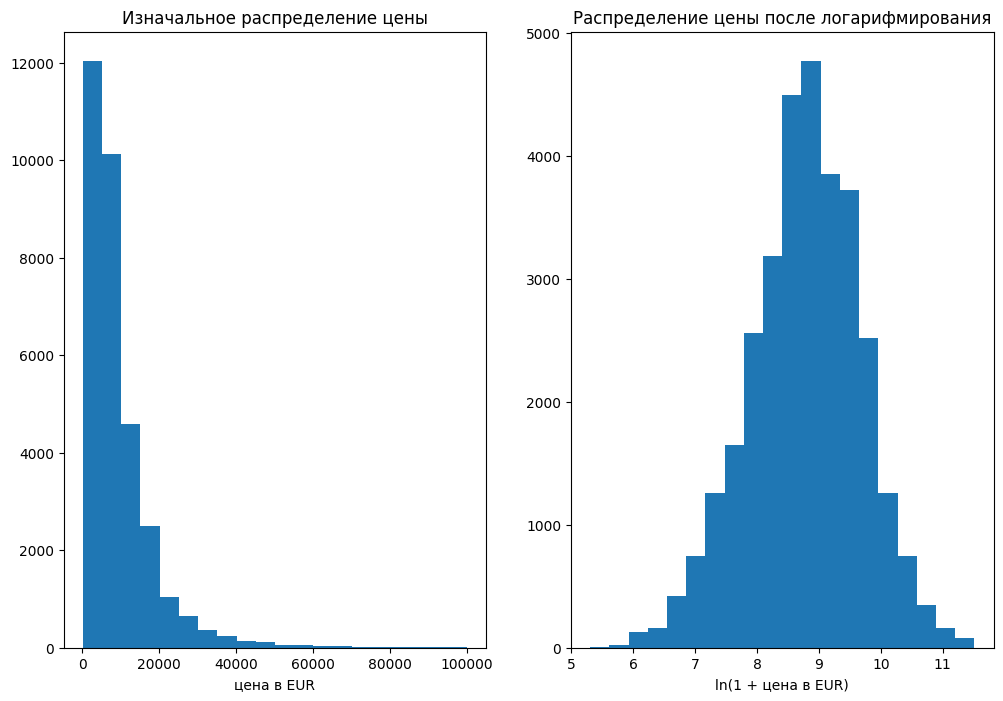

In [15]:
# Проанализируем на проблемные экземпляры, после логарифмирование цены
y_hat = pipe_GS.best_estimator_.predict(X_train)
errors = (np.e ** y_hat + y_train) ** 2

indices = pd.DataFrame(data={'mse': errors}).sort_values(by='mse').iloc[-100:, :].index

cars_df.iloc[indices].sample(20) # Видим что проблема все еще актуальна, в основном модель ошибается с машинами которые сильно дороже медианы и у которых небольшой пробег

# почему помогло логарифмирование
fig = plt.figure(figsize=(12, 8))
plt.subplot(121); plt.hist(cars_df[target], bins=20)
plt.gca().set_xlabel('цена в EUR')
plt.title('Изначальное распределение цены') 
plt.subplot(122); plt.hist(price_power_transformer.transform(cars_df[target]), bins=20)
plt.gca().set_xlabel('ln(1 + цена в EUR)')
plt.title('Распределение цены после логарифмирования')
# Распределение стало более нормальным, что как-то помогло модели

## ОПТИМИЗАЦИЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

Угадываем трансмиссию

In [16]:
# Helpers
target = 'Transmission'
num_cols = cars_df.select_dtypes(include=np.number).columns
cat_cols = cars_df.select_dtypes(exclude=np.number).columns.drop(labels=target)

In [17]:
# Достаем данные
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(cars_df[target])

X_train, X_test, y_train, y_test = train_test_split(cars_df[np.append(num_cols, cat_cols)],
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_STATE)

In [18]:
# Подготовим предобработчики данных
num_imputer = SimpleImputer(strategy='median')
price_scaler = FunctionTransformer(func=np.log1p)
min_max_scaler = MinMaxScaler()

cat_imputer = SimpleImputer(strategy='most_frequent')
cat_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False)

num_pipe = Pipeline([
    ('num_imputer', num_imputer),
    ('min_max_scaler', min_max_scaler) 
    ])
price_pipe = Pipeline([
    ('num_imputer', num_imputer),
    ('price_scaler', price_scaler) 
    ])
cat_pipe = Pipeline([
    ('cat_imputer', cat_imputer),
    ('cat_encoder', cat_encoder) 
    ])

preproccessing = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, num_cols.drop('Price(euro)')),
    ('price_pipe', price_pipe, ['Price(euro)']),
    ('cat_pipe', cat_pipe, cat_cols)
])

model_pipe = Pipeline([
    ('preproccessing', preproccessing),
    ('model', LogisticRegression(solver='saga', C=0.0001, fit_intercept=True, random_state=RANDOM_STATE, max_iter=500))
])

In [56]:
from scipy.stats import uniform
param_grid = {
    "model__C": np.logspace(-4, 4, 5),
    'model__penalty': ['l2', 'l1']
}

pipe_RS = RandomizedSearchCV(estimator = model_pipe, param_distributions=param_grid ,
                             cv=ShuffleSplit(n_splits=3, random_state=42),
                             verbose = 2)
pipe_RS.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.4s
[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.4s
[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.4s
[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.3s
[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.3s
[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.3s
[CV] END ...................model__C=0.01, model__penalty=l2; total time=   1.3s
[CV] END ...................model__C=0.01, model__penalty=l2; total time=   1.3s
[CV] END ...................model__C=0.01, model__penalty=l2; total time=   1.3s
[CV] END ...................model__C=0.01, model__penalty=l1; total time=   1.2s
[CV] END ...................model__C=0.01, model__penalty=l1; total time=   1.2s
[CV] END ...................model__C=0.01, model

/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ....................model__C=1.0, model__penalty=l1; total time=  14.9s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ....................model__C=1.0, model__penalty=l1; total time=  14.8s
[CV] END ....................model__C=1.0, model__penalty=l1; total time=  15.0s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ..................model__C=100.0, model__penalty=l2; total time=  10.0s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ..................model__C=100.0, model__penalty=l2; total time=   9.9s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ..................model__C=100.0, model__penalty=l2; total time=   9.7s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ..................model__C=100.0, model__penalty=l1; total time=  16.6s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ..................model__C=100.0, model__penalty=l1; total time=  16.3s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ..................model__C=100.0, model__penalty=l1; total time=  16.6s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ................model__C=10000.0, model__penalty=l2; total time=   9.9s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ................model__C=10000.0, model__penalty=l2; total time=   9.8s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ................model__C=10000.0, model__penalty=l2; total time=   9.9s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ................model__C=10000.0, model__penalty=l1; total time=  15.0s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ................model__C=10000.0, model__penalty=l1; total time=  15.3s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END ................model__C=10000.0, model__penalty=l1; total time=  15.3s


/Users/pyretttt/masters/mle/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



RandomizedSearchCV(cv=ShuffleSplit(n_splits=3, random_state=42, test_size=None, train_size=None),
                   estimator=Pipeline(steps=[('preproccessing',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('min_max_scaler',
                                                                                                MinMaxScaler())]),
                                                                               Index(['Year', 'Distance', 'Engine_capacity(cm3)', 'km_year'], dtype='o...
                                                                                               ('cat_encoder',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index(['Make', 'Model', 'Style', 'Fuel_type'], dtype='object'))])),
                                             ('model',
                                              LogisticRegression(C=0.0001,
                                                                 max_iter=500,
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   param_distributions={'model__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                                        'model__penalty': ['l2', 'l1']},
                   verbose=2)

In [20]:
display_cv_result(pipe_RS, params=['param_model__penalty', 'param_model__C']) # Неплохой результат

,param_model__penalty,param_model__C,mean_test_score,std_test_score,rank_test_score
6,l2,100.000000,0.848175,0.000000,1
7,l1,100.000000,0.848175,0.000000,1
8,l2,10000.000000,0.848175,0.000000,1
9,l1,10000.000000,0.848175,0.000000,1
4,l2,1.000000,0.847729,0.000000,5
5,l1,1.000000,0.847729,0.000000,5
2,l2,0.010000,0.829475,0.000000,7
3,l1,0.010000,0.820570,0.000000,8
0,l2,0.000100,0.787177,0.000000,9
1,l1,0.000100,0.553874,0.000000,10


In [21]:
y_hat = pipe_RS.best_estimator_.predict(X_train)

indices = np.where(y_hat != y_train)
cars_df.iloc[indices].sample(20) # Особых закономерностей не прослеживается

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year
17718,Ford,Focus,2002,Universal,180000.0,200.0,Metan/Propan,Automatic,2300.0,9000.000000
9381,Volvo,Rare,2018,Sedan,23000.0,2000.0,Petrol,Automatic,27499.0,5750.000000
11852,Mercedes,C Class,2007,Sedan,250000.0,2000.0,Metan/Propan,Automatic,8200.0,16666.666667
18646,Honda,CR-V,2014,Crossover,138000.0,2200.0,Diesel,Automatic,19999.0,17250.000000
8806,Dacia,Logan,2014,Sedan,135000.0,1500.0,Diesel,Manual,5999.0,16875.000000
6659,KIA,Rare,2011,Hatchback,177067.0,1400.0,Diesel,Manual,5899.0,16097.000000
8570,Volvo,XC60,2012,Crossover,245000.0,2400.0,Diesel,Automatic,17450.0,24500.000000
15499,Opel,Astra,2011,Minivan,208000.0,1259.0,Diesel,Manual,6350.0,18909.090909
10681,Mercedes,Rare,2014,Universal,227462.0,1461.0,Diesel,Manual,8099.0,28432.750000
18213,Mercedes,M Class,2008,SUV,300060.0,3000.0,Diesel,Automatic,7777.0,21432.857143


In [22]:
cov_matrix = cars_df.iloc[indices].select_dtypes(np.number).corr()
cm = sns.light_palette("orange", as_cmap=True)
hl = cov_matrix.style.background_gradient(cmap=cm)
display(hl) # нет ничего, что бросалось бы в глаза

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
Year,1.000000,-0.470742,-0.074681,0.541611,0.442144
Distance,-0.470742,1.000000,0.086505,-0.377999,0.414727
Engine_capacity(cm3),-0.074681,0.086505,1.000000,0.419563,-0.038783
Price(euro),0.541611,-0.377999,0.419563,1.000000,0.141413
km_year,0.442144,0.414727,-0.038783,0.141413,1.000000


In [47]:
# Посмотрим метрики и веса

display_metrics(y_hat=pipe_RS.best_estimator_.predict(X_train), y_true=y_train, metrics=[f1_score])

importances = pd.DataFrame(data={
    'Attribute': np.append(num_cols, pipe_RS.best_estimator_['preproccessing'].transformers_[2][1].get_feature_names_out()),
    'Importance': pipe_RS.best_estimator_.steps[-1][-1].coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances.head(10)

import plotly.express as px

fig=px.bar(importances, x="Attribute", y="Importance", color="Importance", color_continuous_scale=px.colors.sequential.Inferno, width=1200, height=800)
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))


f1_score: 0.8687819198134072


# Вывод по весам:
#### 1. Приусы редко бывают с механикой, как и некоторые другие марки и модели авто. Не думаю что это хороший признак для модели чтобы на него завязываться.
#### 2. Новые автомобили в основном с автоматом
#### 3. Гибриды в основном с автоматом
#### 4. Дизельные авто чаще с механикой, как и метан/пропан/ и двс. Странно почему бензиновые авто является признаком чтобы классифицировать авто как механика
#### В целом признаки по которым определяется автомат более общие и грамотные

In [55]:
# Небольшое подтверждение метрик и весов
display(cars_df[cars_df['Model'] == 'Prius']['Transmission'].value_counts())
display(cars_df[cars_df['Fuel_type'] == 'Petrol']['Transmission'].value_counts()) # Незначительная разница, но коэффициент модели большой, это странно

Automatic    317
Manual         2
Name: Transmission, dtype: int64

Manual       6357
Automatic    4727
Name: Transmission, dtype: int64